# Project 1
* Avoid using regular expressions with dictionaries. You should use regexp when your data are strings, not dicitonarie, lists, ..

9/10


In [4]:
# %%  ################--------- Project 1 ---------##################
import pandas as pd
import json, re, time #I think the file has changed since the project was uploaded. I get slightly different age values
#pat_file = 'clinical.project-TCGA-BRCA.2023-03-08.json' #This means the file is in the current directory (working with vscode) else i would repalce with ~/Desktop/Master/Python/scripts/blahblah.json

pat_file = '../clinical.project-TCGA-BRCA.2023-01-10.json'

def proj_1():
    primary_diagnosis = re.compile(r"'primary_diagnosis': '[A-Za-z\, ]*")
    age_of_diagnosis = re.compile(r"'age_at_diagnosis': [0-9None]*") #We add none since it is included in some ages
    my_dict = {}
    some_values_are_like_this = ' None'
    with open(pat_file) as pats:
           
        patients = json.loads(pats.read())
        for i in patients:
            try:
                i['diagnoses'] #Some of the patients do not have a diagnoses (only case_id) so we complement it with this
            except:
                continue
            result = str(i['diagnoses'])
            diag_1 = str(primary_diagnosis.findall(result))
            age_1 = str(age_of_diagnosis.findall(result))
            diag_2 = re.sub("'primary_diagnosis'", '', diag_1)
            diag_3 = re.sub(r"[\[\]\"\:\']", '', diag_2)
            disease = diag_3.lstrip(diag_3[0])
            age_2 = re.sub("'age_at_diagnosis'", '', age_1)
            age_3 = re.sub(r"[\[\]\"\:\']", '', age_2)
            if age_3 == some_values_are_like_this: #I have to add this if since we encounter None
                if not disease in my_dict:
                    mean_age = 0
                    my_dict[disease] = [1, mean_age]
                    continue
                else:
                    continue 
            age = (int(age_3.lstrip(age_3[0])))/365 # It seems some of the patients do not have an age_at_diagnosis, and is marked as none
            if not disease in my_dict:
                mean_age = age
                my_dict[disease] = [1, mean_age]
            else:
                mean_age = (my_dict[disease][1] + age)
                my_dict[disease][0] += 1
                my_dict[disease][1] = mean_age
        my_dict = {key:val for key, val in my_dict.items() if val[0] >= 10} #>= or > ? We do this first to have less data to work with when counting mean 
        for k,v in my_dict.items():
            my_dict[k][1] = (my_dict[k][1]) / (my_dict[k][0])
        my_dict = dict(sorted(my_dict.items(), key=lambda x:x[1][1]))
        my_df = pd.DataFrame(
            [(dis, ags[1]) for dis, ags in my_dict.items()],
            columns=['Diagnosis', 'Average_age_at_diagnosis']
            )
        return my_df
proj_1()
#We have 1097 entries in total, but patient 75 ([74]) does not have diagnosis



,Diagnosis,Average_age_at_diagnosis
0,"Infiltrating duct carcinoma, NOS",58.094956
1,Infiltrating duct and lobular carcinoma,58.718591
2,Infiltrating duct mixed with other types of ca...,60.096467
3,"Metaplastic carcinoma, NOS",61.044814
4,"Lobular carcinoma, NOS",62.125805
5,Mucinous adenocarcinoma,69.125662


# My solution for project 1

In [ ]:
def f_sol():
    #fn = '/Users/admin/Downloads/clinical.project-TCGA-BRCA.2022-04-06.json'
    fn = '/Users/admin/Downloads/clinical.project-TCGA-BRCA.2023-01-21.json'
    with open(fn) as f:
        d = json.load(f)

    p = []
    t = []
    dd = defaultdict(list)
    for x in d:

        if not 'exposures' in x:
            continue
        exposures = x['exposures']

        years_smoked =  exposures[0]['alcohol_history']

        if not 'diagnoses' in x:
            continue

        diagnoses = x['diagnoses']

        primary_diagnosis = diagnoses[0]['primary_diagnosis']
        p.append(primary_diagnosis)
        age_at_diagnosis = diagnoses[0]['age_at_diagnosis']
        if age_at_diagnosis is None or age_at_diagnosis == 'Not Reported':
            continue

        dd[primary_diagnosis].append(age_at_diagnosis/365)

        this_treatment = []
        for treatment in diagnoses[0]['treatments']:
             this_treatment.append(treatment['treatment_type'])
            #print (t)
        t.append(tuple(this_treatment))
        
    dd2 = {k: np.average(v) for k,v in dd.items() if len(v)>10}
    dd3 = defaultdict(list)

    for k,v in sorted(dd2.items(), key=lambda x : x[1]):
        dd3['diagnosis'].append(k)
        dd3['Average age at diagnosis'].append(v)
        
    return pd.DataFrame(dd3)

f_sol()

# Project 2
* `re_pattern = re.compile("[A-Za-z\|\_0-9]*\t")` αυτό πρέπει να το κάνεις μία φορά έξω από το iteration (κοστίζει)
* Όταν κάτι κάνει πολύ ώρα (πάνω από 1 λεπτό), καλό είναι να βάλουμε ένα porgress indicator..

10/10


In [3]:
! ls -l ../mbqc_integrated_otus.tsv.gz

-rw-r--r--  1 admin  staff  12458194 Mar  6 12:24 ../mbqc_integrated_otus.tsv.gz


Reading cols..
  done reading cols


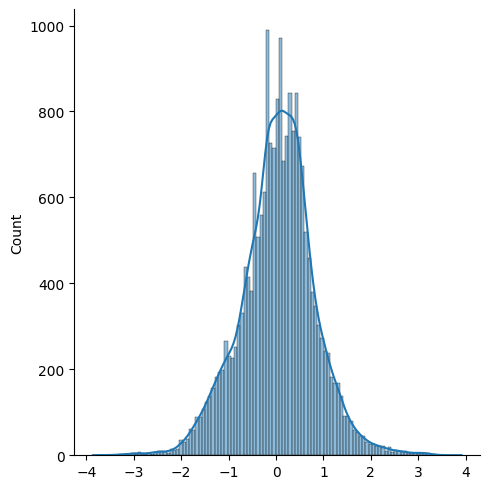

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import math, time, gzip, re

print ('Reading cols..')
my_list = []
h_s = pd.read_csv('../mbqc_integrated_otus.tsv.gz',sep='\t', header = None, compression='gzip', skiprows=27, nrows=1)
healthy_col = list(h_s.columns[h_s.isin(['Healthy']).any()])
healthy_amount = len(healthy_col)
sick_col = list(h_s.columns[h_s.isin(['Sick']).any()])
sick_amount = len(sick_col)
print ('  done reading cols')

with gzip.open('../mbqc_integrated_otus.tsv.gz', 'rt', encoding='utf-8') as plot_data:
    for i in range(72):
        plot_data.readline()
    for j in range(27211): #for i in range(27211):
        re_pattern = re.compile("[A-Za-z\|\_0-9]*\t")
        my_line = plot_data.readline()
        org_tax = re_pattern.search(my_line) #this will search lazy so it saves us time
        start, end = org_tax.span() #we take the end which is the index from where we will start our array
        filtered_string = my_line[end:] #Since .fromstring has issues, we remove everything non-numeric and we replace it later with a sumple 0 in order to keep the indexing we saved from the first part
        microbe = np.fromstring(filtered_string, sep = '\t') #reads the string with tab delimiter
        microbe= np.insert(microbe,0,0) #adding the extra value instead of string to use the list we got from above
        healthy_microbe = (microbe[healthy_col].sum())/healthy_amount
        if not healthy_microbe:
            continue
        sick_microbe = (microbe[sick_col].sum())/sick_amount
        if not sick_microbe:
            continue
        my_list.append(math.log10(sick_microbe/healthy_microbe)) #apparently lists are faster for just appending than it is in an numpy array
plot_array = np.array(my_list)        
sns.displot(plot_array,kde=True)

# Project 3

* `range(12397): #12397 lines`  Never do this! Constants in code. Make your code versatile!


10/10


In [4]:
#import wget
from pathlib import Path
import pandas as pd
import numpy as np


if False:
    Path("./project_3_aggk").mkdir(parents=True, exist_ok=True) #make directory so files wont be a mess
    for i in range(100):
        sc_data = f'https://raw.githubusercontent.com/NielsenBerkeleyLab/sconce/main/test/diploid/simu_healthy_cell_{i}.hg19_lite.bed'
        wget.download(sc_data, f'project_3_aggk/SC_{i}.bed')

    with open(f'project_3_aggk/average_aggk.bed', 'w') as line: # i do this since i used append later in the code. I know it empties the file so i added custom name
        pass


sum_array = np.zeros(shape=(1, 12397))

for j in range(100):
    my_list = []
    with open(f'../simu_healthy_cell_{j}.hg19_lite.bed','r') as sc_file: 
        for lines in range(12397): #12397 lines
            cnv_count = (sc_file.readline().strip()).split('\t')[3]
            my_list.append(cnv_count)
        cnv_array = np.array(my_list, dtype=float)
        sum_array = np.add(sum_array,cnv_array)
        
mean_sum_array = sum_array/100



with open(f'../simu_healthy_cell_0.hg19_lite.bed', 'r') as read_line: #does not matter which one we open since all of the files have identical first 3 columns
    for t in range(12397):
        to_write = read_line.readline().strip().split('\t')[:-1]
        cvn_mean = str(mean_sum_array[0][t])
        to_write.append(cvn_mean)
        line_to_write = '\t'.join(to_write)
        with open(f'average_aggk.bed', 'a') as line: # i do this since i used append later in the code. I know it empties the file so i added custom name
            line.write(f'{line_to_write}\n')
            
            

In [5]:
! head average_aggk.bed

chr1	0	250000	322.85
chr1	250000	500000	324.23
chr1	500000	750000	319.01
chr1	750000	1000000	319.74
chr1	1000000	1250000	310.61
chr1	1250000	1500000	317.59
chr1	1500000	1750000	326.47
chr1	1750000	2000000	321.61
chr1	2000000	2250000	329.07
chr1	2250000	2500000	319.65


In [6]:
! tail average_aggk.bed

chrY	57000000	57250000	328.6
chrY	57250000	57500000	316.39
chrY	57500000	57750000	324.13
chrY	57750000	58000000	326.78
chrY	58000000	58250000	327.01
chrY	58250000	58500000	326.52
chrY	58500000	58750000	311.5
chrY	58750000	59000000	322.06
chrY	59000000	59250000	315.52
chrY	59250000	59373566	321.91


# Project 5

10/10


Text(0, 0.5, 'pval 5vs0min')

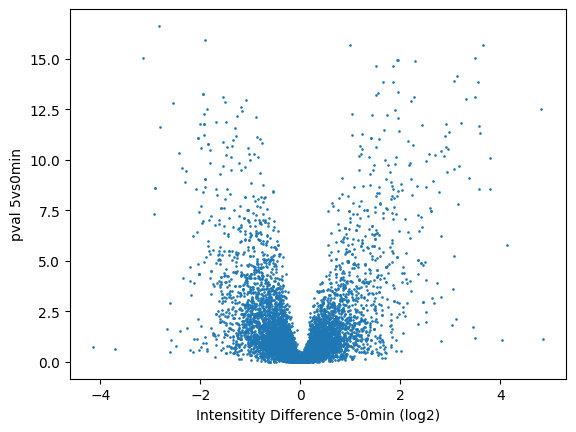

In [1]:
import pandas as pd
import matplotlib.pylab as plot

data = pd.read_csv('https://raw.githubusercontent.com/saezlab/kinact/master/kinact/data/deGraaf_2014_jurkat.csv')
volcano_data = data[['Average Log2 Intensity 0min','Average Log2 Intensity 5min','p value_5vs0min']].copy()
volcano_data['Intensity Difference 5min-0min (log2)'] = volcano_data['Average Log2 Intensity 5min'] - volcano_data['Average Log2 Intensity 0min']
plot.scatter(x=volcano_data['Intensity Difference 5min-0min (log2)'],y=volcano_data['p value_5vs0min'], s=0.8) 
plot.xlabel("Intensitity Difference 5-0min (log2)")
plot.ylabel("pval 5vs0min")



# Project 6

10/10


In [3]:
import numpy as np

# %% ################--------- Project 6 ---------##################
def list_to_dict(strng):
    lst = list(strng)
    letter_indexes = {}
    indx = 0
    for i in lst:
        if not i in letter_indexes:
            letter_indexes[i] = []
            letter_indexes[i].append(indx)
            indx += 1
        else:
            letter_indexes[i].append(indx)
            indx += 1
    return letter_indexes 

def proj_6(x):
        letter_positions = list_to_dict(x)
        let_ind = { v:k for k,v in list(enumerate(sorted(set(x)))) } #Gives one hot
        one_hot_arr = np.zeros(shape=(len(x), len(set(x))), dtype=int)
        for uniq_let in list(set(x)):
            #print(uniq_let)
            for ltind in letter_positions[uniq_let]:
                dummy_2 = let_ind[uniq_let]
                one_hot_arr[ltind][dummy_2] = 1
        return one_hot_arr

proj_6('kanterakis')

array([[0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0]])

In [4]:
proj_6('a')

array([[1]])

In [5]:
proj_6('aaaa')

array([[1],
       [1],
       [1],
       [1]])

In [6]:
proj_6('abaaa')

array([[1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0]])

In [7]:
proj_6('abcdefg')

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]])

# Project 7

* Γενικότερα αποφέυγουμε να λύσουμε μία άσκηση με strings όταν μπορούμε να τη λύσουμε χωρίς strings. Τα regexps που βάζεις δεν χρειάζονται. 

9/10


H λύση μου:

In [6]:
def f_sol(l):
    G = nx.DiGraph()

    labels = {}

    for seq in l:
        
        l2 = [(s,i) for i,s in enumerate(seq) if s != '-']
        
        for a,b in zip(l2, l2[1:]):
            
            G.add_edge(a,b)
            labels[a] = f'{a[0]}:{a[1]}'
            labels[b] = f'{b[0]}:{b[1]}'

    pos = nx.circular_layout(G)
    nx.draw_networkx(G,pos, labels=labels, with_labels = True)

H λύση σου:

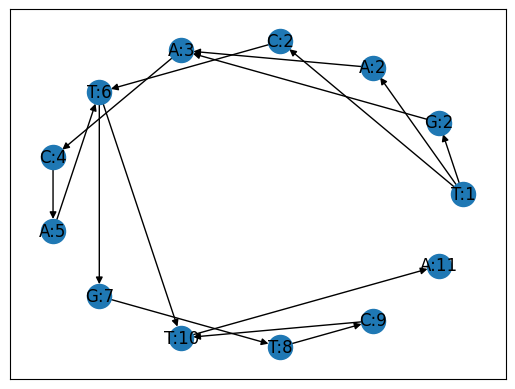

In [1]:
import re
import networkx as nx

def uniq_wo_chng(thelist):
    seen = set()
    seen_add = seen.add
    return [x_1 for x_1 in thelist if not (x_1 in seen or seen_add(x_1))]

def indexing(motifs):
    lst = [list(seq) for seq in motifs]
    letter_indexes = {}
    position_index = {}
    str_tst = ''
    final_node_str = ''
    node_list = []
    nodes = 0
    
    for i in lst:
        indx = 1
        for j in i:
            if not j in letter_indexes:
                letter_indexes[j] = []
                letter_indexes[j].append(indx)
                indx += 1
            else:
                letter_indexes[j].append(indx)
                letter_indexes[j] = sorted(set(letter_indexes[j]))
                indx += 1
        indx = 1
        for i_1 in i:
            if not indx in position_index:
                position_index[indx] = []
                position_index[indx].append(i_1)
                indx += 1
            else:
                position_index[indx].append(i_1)
                position_index[indx] = uniq_wo_chng(position_index[indx])
                indx += 1  
    for k in letter_indexes:
        if k != '-':
            nodes += len(letter_indexes[k])
    dum_pos = sorted(range(1,nodes+1), reverse=True)
    for i_2 in range(1,len(motifs[0])+1):
        for i_3 in position_index[i_2]:
            if i_3 == '-':
                continue
            create_string = f'Κόμβος {dum_pos[-1]} --> Θέση:{i_2} βάση:{i_3}'   
            str_tst = '\n'.join([str_tst,create_string]) #This is the string with all my nodes, position and nucleotide
            dum_pos.pop()
    node_labels = re.findall(r'Κόμβος (\d+) --> Θέση:(\d+) βάση:(\w)', str_tst)
    node_labels = {x[0]: f'{x[2]}:{x[1]}' for x in node_labels} #int x[0]
    for motif_node in lst:
        for pstn in range(1,len(motif_node)+1):
            nucleotide = motif_node[(pstn-1)]
            if nucleotide == '-':
                continue
            re_get_node = re.compile(f'Κόμβος [\d]+ --> Θέση:{pstn} βάση:{nucleotide}')
            got_node = str(re_get_node.findall(str_tst))
            got_node = re.sub(f'[^\d-]','',got_node)
            got_node = got_node.split('--')[0]
            if got_node:
                node_list.append(got_node)
                got_node = ''
                continue
        ind_count = 1
        for i_4 in node_list:
            if int(i_4) == int(node_list[-1]):
                continue
            next_node = int(node_list[ind_count])
            all_node_str = f'({i_4},{next_node})'
            if all_node_str in final_node_str:
                ind_count += 1
                continue
            ind_count += 1
            final_node_str = '\n'.join([final_node_str,all_node_str])    
        node_list = []
        
    anoth = final_node_str.replace('\n','',1).split('\n') #remove the first new line
    anoth = str(sorted([eval(n_tup) for n_tup in anoth], key = lambda x: (x[0], x[1])))
    anoth = re.sub('[\[\]]','',anoth)
    G = nx.DiGraph()
    edges = re.findall(r'\((\d+), (\d+)\)', anoth)
    for s_ed in edges:
        G.add_edge(s_ed[0], s_ed[1])
    pos = nx.circular_layout(G)
    return nx.draw_networkx(G,pos, labels=node_labels, with_labels = True) 

l = [
    'TGACAT---TA',
    'TAACATGTCTA',
    'TC---T---TA',]

indexing(l)

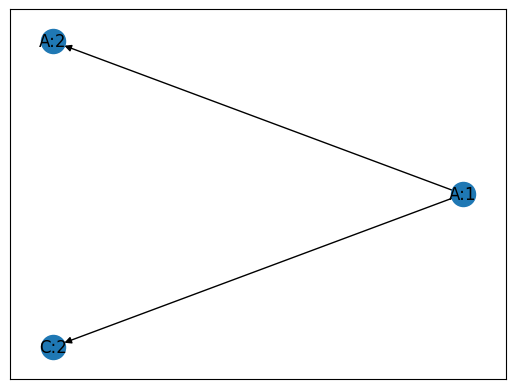

In [3]:
indexing(['AA', 'AC'])

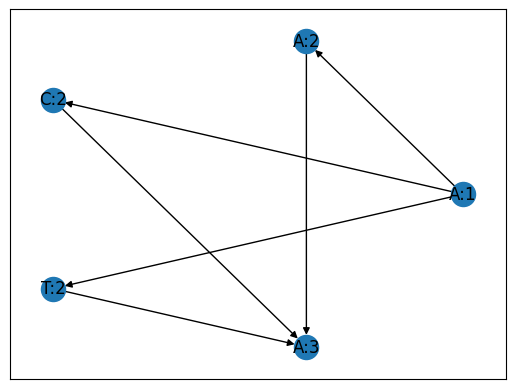

In [4]:
indexing(['AAA', 'ACA', 'ATA'])

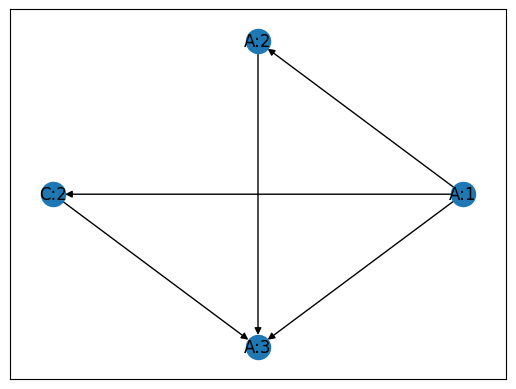

In [5]:
indexing(['AAA', 'ACA', 'A-A'])

# Project 8

Έπρεπε να του αλλάξω κάποιες γραμμες για να παίξει (check comment)

8/10


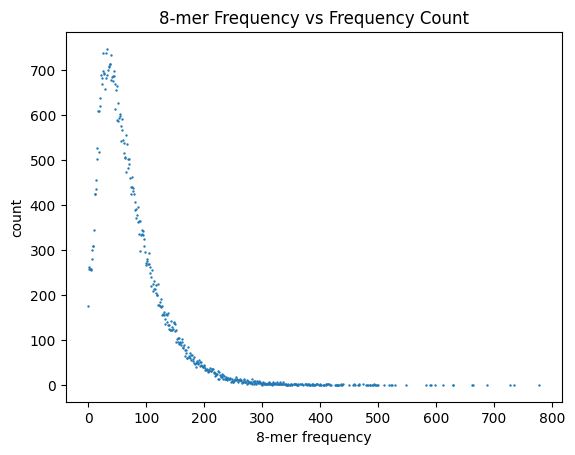

In [6]:
import itertools, re, time
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def get_lines(fl):
    with open(f'{fl}') as get_lines:
        line_number = list(enumerate(get_lines))[-1][0]+1
    return line_number

whole_seq = ''
with open('../sequence.fasta') as e_col:
    e_col.readline()
    # ALEX CORRECTION
    #for i in range(get_lines('../sequence.fasta')):
    for one_line in e_col:
        #one_line = e_col.readline()
        whole_seq = ''.join([whole_seq,one_line])
whole_seq = re.sub(r'\n','',whole_seq)
eightmers = itertools.product(*itertools.repeat(['A','T','G','C'], 8))
dict_mers = {}
for rnd in eightmers:
    dict_mers[''.join(list(rnd))] = 0 #create a dictionary with all 65536 possible 8mers

for j in range(len(whole_seq)-8+1): #we assign each time we find an 8mer to the dictionary, moving at a pace of 1 nucleotide from left to right at a time
    motif = j+8
    e_mer = whole_seq[j:motif]
    dict_mers[e_mer] += 1


#filtered_dict_mers = {k:v for k,v in dict_mers.items() if v != 0} #65360 ... Only 176 not found! # We would use this to filter, but no need to here
all_kmer_occurences = list(dict_mers.values())
occurence_counter = dict(Counter(all_kmer_occurences))


axis_x = np.array([k_1 for k_1,v_1 in occurence_counter.items()]) #frequency
axis_y = np.array([v_2 for k_2,v_2 in occurence_counter.items()]) #count

plt.scatter(axis_x, axis_y,s=0.5)
plt.title("8-mer Frequency vs Frequency Count")
plt.xlabel("8-mer frequency")
plt.ylabel("count")
plt.show()

# Project 9

εξαιρετικά αργή υλοποίηση:

1. Δεν χρησιμοποιούμε pandas για να βρούμε ΕΝΑ στοιχείο από ένα τεράστιο αρχείο, μόνο μία φορά.. Εξαιρετικά μεγάλη σπατάλη μνήμης/cpu. 
2. Όταν έχουμε μία απλή αντιστοίχιση π.χ. IDS --> Names χρησιμοποιύμε dictionaries. Είναι εκατοντάδες φορές πιο γρήγορα από pandas...

Έχω υλοποιήσει τα παραπάνω. Πρόσεξε τη διαφορά στη ταχύτητα

8/10

In [25]:
#import wget, tarfile
from pathlib import Path
import pandas as pd 
import numpy as np
from numpy import genfromtxt
import re, time 



#Path("./project_9_aggk").mkdir(parents=True, exist_ok=True) #make directory so files wont be a mess
#p9_data = f'https://ftp.ncbi.nih.gov/pub/taxonomy/taxdump.tar.gz'
#wget.download(p9_data, f'project_9_aggk/taxdump.tar.gz')

#p9_data = tarfile.open(f'project_9_aggk/taxdump.tar.gz')
#p9_data.extractall(f'./project_9_aggk')
#p9_data.close()


print ('Reading data..')

node_array = genfromtxt('../nodes.dmp', delimiter='|', usecols=[0,1],dtype=int)
my_pd = pd.DataFrame(node_array)
my_headers =  ['Organism Id','Parent Node']
my_pd.columns = my_headers

# Alex: speed(Dictionaries) >>>> speed(pandas)
# Alternatively you could have changed the index of pandas. That would had the same effect in speed.
my_pd_dict = {x['Organism Id'] : x['Parent Node'] for x in my_pd.to_dict('records')}
print ('  done reading data')

def get_org_id(strng):
    #print (strng)
    with open('../names.dmp') as f:
        for l in f:
            ls = l.split('|')
            org_id = int(ls[0].strip())
            org_name = ls[1].strip()
            if org_name == strng:
                return org_id
    
    # Alex: Pandas is for 2D analysis not for locating ONE thing in a huge file..
    
    #with pd.read_table('../names.dmp', sep='|', usecols=[0,1], header = None, index_col=None, chunksize=1, encoding='utf-8') as f_2:
    #    for line_2 in f_2:
    #        line_2[1] = line_2[1].str.strip('\t')
    #        org_name = str(line_2[1].values[0])
    #        org_id =  int(line_2[0].values[0])   
    #        if strng == org_name:
    #            return org_id

def get_tree(org_name):
    
    first_id = get_org_id(org_name)
    p9_list = [first_id]
    while first_id != 1:
        #parent_node = my_pd.loc[my_pd['Organism Id'] == first_id ]['Parent Node'].values[0]
        parent_node = my_pd_dict[first_id] # <-- Alex: This makes it 100 times faster
        p9_list.append(parent_node)
        first_id = parent_node

    return p9_list


def distance(o_1,o_2):
    org_1 = get_tree(o_1)
    org_2 = get_tree(o_2)
    for i in org_1:
        if i in org_2:
            break
        
    return (org_1.index(i)+1 + org_2.index(i)+1)



distance('Homo sapiens', 'Felis catus')

Reading data..
  done reading data


19

In [26]:
distance('Homo sapiens', 'Felis catus')

19

In [27]:
distance('Homo sapiens', 'Pan troglodytes') # άνθρωπος <--> χιμπαντζής

6

# Project 10

Nice!

10/10


In [3]:
#import wget
import gzip
from pathlib import Path
import itertools, time

start_time = time.time()


#Path("./project_10_aggk").mkdir(parents=True, exist_ok=True) #make directory so files wont be a mess

#p10_data = f'http://ftp.ensembl.org/pub/release-105/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.22.fa.gz'
#wget.download(p10_data, f'project_10_aggk/chr22.fa.gz')

def generate_seq():
    s = ''
    with gzip.open(f'../Homo_sapiens.GRCh38.dna.chromosome.22.fa.gz', 'rt') as f:
        for i, l in enumerate(f):
            if i==0:
                continue
            if i%50_000 == 0:
                print (f'{i}')
            s += l.strip().replace('N','')
    return s


def get_motif():
    all_seq = generate_seq()
    for j in range(3,100): #I chose 3 because there is no way 2-mers wont exist (not that 3 changes it but still)
        kmers = itertools.product(*itertools.repeat(['A','T','G','C'], j))
        dict_mers = {}
        for rnd in kmers:
            dict_mers[''.join(list(rnd))] = 0 
        for n in dict_mers.keys():
            if n in all_seq:
                continue
            else:
                got_it = f'{n} is the smallest motif not found'
                return got_it
                
print(get_motif())

                
end_time = time.time()
print(end_time - start_time)

50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
AAATACGCG is the smallest motif not found
67.16218709945679


In [2]:
! ls -l ../chr*

ls: ../chr*: No such file or directory


In [ ]:
# %%  ################--------- Project 1 ---------##################
import pandas as pd
import json, re, time #I think the file has changed since the project was uploaded. I get slightly different age values
pat_file = 'clinical.project-TCGA-BRCA.2023-03-08.json' #This means the file is in the current directory (working with vscode) else i would repalce with ~/Desktop/Master/Python/scripts/blahblah.json
def proj_1():
    primary_diagnosis = re.compile(r"'primary_diagnosis': '[A-Za-z\, ]*")
    age_of_diagnosis = re.compile(r"'age_at_diagnosis': [0-9None]*") #We add none since it is included in some ages
    my_dict = {}
    some_values_are_like_this = ' None'
    with open(pat_file) as pats:
           
        patients = json.loads(pats.read())
        for i in patients:
            try:
                i['diagnoses'] #Some of the patients do not have a diagnoses (only case_id) so we complement it with this
            except:
                continue
            result = str(i['diagnoses'])
            diag_1 = str(primary_diagnosis.findall(result))
            age_1 = str(age_of_diagnosis.findall(result))
            diag_2 = re.sub("'primary_diagnosis'", '', diag_1)
            diag_3 = re.sub(r"[\[\]\"\:\']", '', diag_2)
            disease = diag_3.lstrip(diag_3[0])
            age_2 = re.sub("'age_at_diagnosis'", '', age_1)
            age_3 = re.sub(r"[\[\]\"\:\']", '', age_2)
            if age_3 == some_values_are_like_this: #I have to add this if since we encounter None
                if not disease in my_dict:
                    mean_age = 0
                    my_dict[disease] = [1, mean_age]
                    continue
                else:
                    continue 
            age = (int(age_3.lstrip(age_3[0])))/365 # It seems some of the patients do not have an age_at_diagnosis, and is marked as none
            if not disease in my_dict:
                mean_age = age
                my_dict[disease] = [1, mean_age]
            else:
                mean_age = (my_dict[disease][1] + age)
                my_dict[disease][0] += 1
                my_dict[disease][1] = mean_age
        my_dict = {key:val for key, val in my_dict.items() if val[0] >= 10} #>= or > ? We do this first to have less data to work with when counting mean 
        for k,v in my_dict.items():
            my_dict[k][1] = (my_dict[k][1]) / (my_dict[k][0])
        my_dict = dict(sorted(my_dict.items(), key=lambda x:x[1][1]))
        my_df = pd.DataFrame(
            [(dis, ags[1]) for dis, ags in my_dict.items()],
            columns=['Diagnosis', 'Average_age_at_diagnosis']
            )
        return my_df
proj_1()
#We have 1097 entries in total, but patient 75 ([74]) does not have diagnosis





# %% ################--------- Project 2 ---------##################
import pandas as pd
import numpy as np
import seaborn as sns
import math, time, gzip, re

my_list = []
h_s = pd.read_csv('mbqc_integrated_otus.tsv.gz',sep='\t', header = None, compression='gzip', skiprows=27, nrows=1)
healthy_col = list(h_s.columns[h_s.isin(['Healthy']).any()])
healthy_amount = len(healthy_col)
sick_col = list(h_s.columns[h_s.isin(['Sick']).any()])
sick_amount = len(sick_col)

with gzip.open('mbqc_integrated_otus.tsv.gz', 'rt', encoding='utf-8') as plot_data:
    for i in range(72):
        plot_data.readline()
    for j in range(27211): #for i in range(27211):
        re_pattern = re.compile("[A-Za-z\|\_0-9]*\t")
        my_line = plot_data.readline()
        org_tax = re_pattern.search(my_line) #this will search lazy so it saves us time
        start, end = org_tax.span() #we take the end which is the index from where we will start our array
        filtered_string = my_line[end:] #Since .fromstring has issues, we remove everything non-numeric and we replace it later with a sumple 0 in order to keep the indexing we saved from the first part
        microbe = np.fromstring(filtered_string, sep = '\t') #reads the string with tab delimiter
        microbe= np.insert(microbe,0,0) #adding the extra value instead of string to use the list we got from above
        healthy_microbe = (microbe[healthy_col].sum())/healthy_amount
        if not healthy_microbe:
            continue
        sick_microbe = (microbe[sick_col].sum())/sick_amount
        if not sick_microbe:
            continue
        my_list.append(math.log10(sick_microbe/healthy_microbe)) #apparently lists are faster for just appending than it is in an numpy array
plot_array = np.array(my_list)        
sns.displot(plot_array,kde=True)



# %% ################--------- Project 3 ---------##################
import wget
from pathlib import Path
import pandas as pd
import numpy as np


Path("./project_3_aggk").mkdir(parents=True, exist_ok=True) #make directory so files wont be a mess
for i in range(100):
    sc_data = f'https://raw.githubusercontent.com/NielsenBerkeleyLab/sconce/main/test/diploid/simu_healthy_cell_{i}.hg19_lite.bed'
    wget.download(sc_data, f'project_3_aggk/SC_{i}.bed')

with open(f'project_3_aggk/average_aggk.bed', 'w') as line: # i do this since i used append later in the code. I know it empties the file so i added custom name
    pass


sum_array = np.zeros(shape=(1, 12397))

for j in range(100):
    my_list = []
    with open(f'project_3_aggk/SC_{j}.bed','r') as sc_file: 
        for lines in range(12397): #12397 lines
            cnv_count = (sc_file.readline().strip()).split('\t')[3]
            my_list.append(cnv_count)
        cnv_array = np.array(my_list, dtype=float)
        sum_array = np.add(sum_array,cnv_array)
        
mean_sum_array = sum_array/100

with open(f'project_3_aggk/SC_0.bed', 'r') as read_line: #does not matter which one we open since all of the files have identical first 3 columns
    for t in range(12397):
        to_write = read_line.readline().strip().split('\t')[:-1]
        cvn_mean = str(mean_sum_array[0][t])
        to_write.append(cvn_mean)
        line_to_write = '\t'.join(to_write)
        with open(f'project_3_aggk/average_aggk.bed', 'a') as line: # i do this since i used append later in the code. I know it empties the file so i added custom name
            line.write(f'{line_to_write}\n')
            
            
            

# %% ################--------- Project 5 ---------##################
import pandas as pd
import matplotlib.pylab as plot

data = pd.read_csv('https://raw.githubusercontent.com/saezlab/kinact/master/kinact/data/deGraaf_2014_jurkat.csv')
volcano_data = data[['Average Log2 Intensity 0min','Average Log2 Intensity 5min','p value_5vs0min']].copy()
volcano_data['Intensity Difference 5min-0min (log2)'] = volcano_data['Average Log2 Intensity 5min'] - volcano_data['Average Log2 Intensity 0min']
plot.scatter(x=volcano_data['Intensity Difference 5min-0min (log2)'],y=volcano_data['p value_5vs0min'], s=0.8) 
plot.xlabel("Intensitity Difference 5-0min (log2)")
plot.ylabel("pval 5vs0min")



# %% ################--------- Project 6 ---------##################
def list_to_dict(strng):
    lst = list(strng)
    letter_indexes = {}
    indx = 0
    for i in lst:
        if not i in letter_indexes:
            letter_indexes[i] = []
            letter_indexes[i].append(indx)
            indx += 1
        else:
            letter_indexes[i].append(indx)
            indx += 1
    return letter_indexes 

def proj_6(x):
        letter_positions = list_to_dict(x)
        let_ind = { v:k for k,v in list(enumerate(sorted(set(x)))) } #Gives one hot
        one_hot_arr = np.zeros(shape=(len(x), len(set(x))), dtype=int)
        for uniq_let in list(set(x)):
            print(uniq_let)
            for ltind in letter_positions[uniq_let]:
                dummy_2 = let_ind[uniq_let]
                one_hot_arr[ltind][dummy_2] = 1
        return one_hot_arr

print(proj_6('kanterakis'))



# %% ################--------- Project 7 ---------################## No idea what i'm doing


import re
import networkx as nx

def uniq_wo_chng(thelist):
    seen = set()
    seen_add = seen.add
    return [x_1 for x_1 in thelist if not (x_1 in seen or seen_add(x_1))]

def indexing(motifs):
    lst = [list(seq) for seq in motifs]
    letter_indexes = {}
    position_index = {}
    str_tst = ''
    final_node_str = ''
    node_list = []
    nodes = 0
    
    for i in lst:
        indx = 1
        for j in i:
            if not j in letter_indexes:
                letter_indexes[j] = []
                letter_indexes[j].append(indx)
                indx += 1
            else:
                letter_indexes[j].append(indx)
                letter_indexes[j] = sorted(set(letter_indexes[j]))
                indx += 1
        indx = 1
        for i_1 in i:
            if not indx in position_index:
                position_index[indx] = []
                position_index[indx].append(i_1)
                indx += 1
            else:
                position_index[indx].append(i_1)
                position_index[indx] = uniq_wo_chng(position_index[indx])
                indx += 1  
    for k in letter_indexes:
        if k != '-':
            nodes += len(letter_indexes[k])
    dum_pos = sorted(range(1,nodes+1), reverse=True)
    for i_2 in range(1,len(motifs[0])+1):
        for i_3 in position_index[i_2]:
            if i_3 == '-':
                continue
            create_string = f'Κόμβος {dum_pos[-1]} --> Θέση:{i_2} βάση:{i_3}'   
            str_tst = '\n'.join([str_tst,create_string]) #This is the string with all my nodes, position and nucleotide
            dum_pos.pop()
    node_labels = re.findall(r'Κόμβος (\d+) --> Θέση:(\d+) βάση:(\w)', str_tst)
    node_labels = {x[0]: f'{x[2]}:{x[1]}' for x in node_labels} #int x[0]
    for motif_node in lst:
        for pstn in range(1,len(motif_node)+1):
            nucleotide = motif_node[(pstn-1)]
            if nucleotide == '-':
                continue
            re_get_node = re.compile(f'Κόμβος [\d]+ --> Θέση:{pstn} βάση:{nucleotide}')
            got_node = str(re_get_node.findall(str_tst))
            got_node = re.sub(f'[^\d-]','',got_node)
            got_node = got_node.split('--')[0]
            if got_node:
                node_list.append(got_node)
                got_node = ''
                continue
        ind_count = 1
        for i_4 in node_list:
            if int(i_4) == int(node_list[-1]):
                continue
            next_node = int(node_list[ind_count])
            all_node_str = f'({i_4},{next_node})'
            if all_node_str in final_node_str:
                ind_count += 1
                continue
            ind_count += 1
            final_node_str = '\n'.join([final_node_str,all_node_str])    
        node_list = []
        
    anoth = final_node_str.replace('\n','',1).split('\n') #remove the first new line
    anoth = str(sorted([eval(n_tup) for n_tup in anoth], key = lambda x: (x[0], x[1])))
    anoth = re.sub('[\[\]]','',anoth)
    G = nx.DiGraph()
    edges = re.findall(r'\((\d+), (\d+)\)', anoth)
    for s_ed in edges:
        G.add_edge(s_ed[0], s_ed[1])
    pos = nx.circular_layout(G)
    return nx.draw_networkx(G,pos, labels=node_labels, with_labels = True) 

l = [
    'TGACAT---TA',
    'TAACATGTCTA',
    'TC---T---TA',]

indexing(l)


# %% ################--------- Project 8 ---------##################
import itertools, re, time
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def get_lines(fl):
    with open(f'{fl}') as get_lines:
        line_number = list(enumerate(get_lines))[-1][0]+1
    return line_number

whole_seq = ''
with open('e_coli.fa') as e_col:
    for i in range(get_lines('e_coli.fa')):
        one_line = e_col.readline()
        whole_seq = ''.join([whole_seq,one_line])
whole_seq = re.sub(r'\n','',whole_seq)
eightmers = itertools.product(*itertools.repeat(['A','T','G','C'], 8))
dict_mers = {}
for rnd in eightmers:
    dict_mers[''.join(list(rnd))] = 0 #create a dictionary with all 65536 possible 8mers

for j in range(len(whole_seq)-8+1): #we assign each time we find an 8mer to the dictionary, moving at a pace of 1 nucleotide from left to right at a time
    motif = j+8
    e_mer = whole_seq[j:motif]
    dict_mers[e_mer] += 1


#filtered_dict_mers = {k:v for k,v in dict_mers.items() if v != 0} #65360 ... Only 176 not found! # We would use this to filter, but no need to here
all_kmer_occurences = list(dict_mers.values())
occurence_counter = dict(Counter(all_kmer_occurences))


axis_x = np.array([k_1 for k_1,v_1 in occurence_counter.items()]) #frequency
axis_y = np.array([v_2 for k_2,v_2 in occurence_counter.items()]) #count

plt.scatter(axis_x, axis_y,s=0.5)
plt.title("8-mer Frequency vs Frequency Count")
plt.xlabel("8-mer frequency")
plt.ylabel("count")
plt.show()



# %% ################--------- Project 9 ---------##################

import wget, tarfile
from pathlib import Path
import pandas as pd 
import numpy as np
from numpy import genfromtxt
import re, time 



Path("./project_9_aggk").mkdir(parents=True, exist_ok=True) #make directory so files wont be a mess
p9_data = f'https://ftp.ncbi.nih.gov/pub/taxonomy/taxdump.tar.gz'
wget.download(p9_data, f'project_9_aggk/taxdump.tar.gz')

p9_data = tarfile.open(f'project_9_aggk/taxdump.tar.gz')
p9_data.extractall(f'./project_9_aggk')
p9_data.close()

node_array = genfromtxt('project_9_aggk/nodes.dmp', delimiter='|', usecols=[0,1],dtype=int)
my_pd = pd.DataFrame(node_array)
my_headers =  ['Organism Id','Parent Node']
my_pd.columns = my_headers
    

def get_org_id(strng):
    with pd.read_table('project_9_aggk/names.dmp', sep='|', usecols=[0,1], header = None, index_col=None, chunksize=1, encoding='utf-8') as f_2:
        for line_2 in f_2:
            line_2[1] = line_2[1].str.strip('\t')
            org_name = str(line_2[1].values[0])
            org_id =  int(line_2[0].values[0])   
            if strng == org_name:
                return org_id

def get_tree(org_name):
    
    first_id = get_org_id(org_name)
    p9_list = [first_id]
    while first_id != 1:
        parent_node = my_pd.loc[my_pd['Organism Id'] == first_id ]['Parent Node'].values[0]
        p9_list.append(parent_node)
        first_id = parent_node

    return p9_list


def distance(o_1,o_2):
    org_1 = get_tree(o_1)
    org_2 = get_tree(o_2)
    for i in org_1:
        if i in org_2:
            break
        
    return (org_1.index(i)+1 + org_2.index(i)+1)

print(distance('Homo sapiens', 'Felis catus'))




# %% ################--------- Project 10 ---------##################

import wget, gzip
from pathlib import Path
import itertools, time

start_time = time.time()


Path("./project_10_aggk").mkdir(parents=True, exist_ok=True) #make directory so files wont be a mess

p10_data = f'http://ftp.ensembl.org/pub/release-105/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.22.fa.gz'
wget.download(p10_data, f'project_10_aggk/chr22.fa.gz')

def generate_seq():
    s = ''
    with gzip.open(f'./project_10_aggk/chr22.fa.gz', 'rt') as f:
        for i, l in enumerate(f):
            if i==0:
                continue
            if i%50_000 == 0:
                print (f'{i}')
            s += l.strip().replace('N','')
    return s


def get_motif():
    all_seq = generate_seq()
    for j in range(3,100): #I chose 3 because there is no way 2-mers wont exist (not that 3 changes it but still)
        kmers = itertools.product(*itertools.repeat(['A','T','G','C'], j))
        dict_mers = {}
        for rnd in kmers:
            dict_mers[''.join(list(rnd))] = 0 
        for n in dict_mers.keys():
            if n in all_seq:
                continue
            else:
                got_it = f'{n} is the smallest motif not found'
                return got_it
                
print(get_motif())

                
end_time = time.time()
print(end_time - start_time)